# In this notebook i will benchmark my models and their RAG

In [123]:
import os
from dotenv import load_dotenv
import openai
import chromadb
import tiktoken
import sqlite3
import nltk
from nltk.tokenize import word_tokenize
from rank_bm25 import BM25Okapi
from sentence_transformers import CrossEncoder
import time
import functools
import matplotlib.pyplot as plt
import pickle
from IPython.display import Markdown, display
import requests
import json
from enum import Enum
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from collections import defaultdict


In [2]:
load_dotenv()

True

In [3]:
OPEN_AI_API_KEY = os.getenv("OPENAI_API_KEY")
CHROMA_DB_PATH = "./../data_collecting/chroma_db"

In [ ]:
client = chromadb.PersistentClient(path=CHROMA_DB_PATH)
collection = client.get_or_create_collection(name="python_data")

In [4]:
openai.api_key = OPEN_AI_API_KEY 

## RAG testing

In [ ]:
test_questions = [
    """How does the if __name__ == "__main__" statement work in Python?""",
    "What are the differences between deepcopy() and copy() in the copy module?",
    "What is a KeyError and when does it occur?",
    "How do you use try / except / finally for exception handling?",
    "How does defaultdict work in the collections module?",
    "What is the difference between set() and frozenset()?",
    "How does asyncio.run() work and when should you use it?",
    "How can you use asyncio.gather() to run multiple coroutines concurrently?",
    "What is a dataclass and how does it compare to a regular class?"
]

In [ ]:
def get_openai_embedding(text):
    response = openai.embeddings.create(
        input=[text],
        model="text-embedding-ada-002"
    )
    return response.data[0].embedding

In [ ]:
def find_relevant_docs(query, top_k=3):
    query_embedding = get_openai_embedding(query)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k * 2 
    )

    seen = set()
    unique_docs = []
    
    for doc in results["documents"][0]:
        if doc not in seen:
            seen.add(doc)
            unique_docs.append(doc)
        if len(unique_docs) == top_k:
            break 
            
    return unique_docs

In [ ]:
query = test_questions[1]
auto_assigned_docs = find_relevant_docs(query, top_k=30)

for i, doc in enumerate(auto_assigned_docs):
    print(f"{i}"*10)
    print("-"*100)
    display(Markdown(doc))

In [ ]:
auto_assigned_docs

In [ ]:
correct_answers = []

In [ ]:
correct_answers.append({"question": test_questions[0], "correct_answers": [auto_assigned_docs[1], auto_assigned_docs[2], auto_assigned_docs[8]]})

In [ ]:
correct_answers.append({"question": test_questions[1], "correct_answers": [auto_assigned_docs[0], auto_assigned_docs[2], auto_assigned_docs[6]]})


## LLM as a judge

In [5]:
class ChatModelStrategyEnum(Enum):
    VECTOR = "vector"
    VECTOR_BM25 = "vector_bm25"
    VECTOR_RERANK = "vector_rerank"
    VECTOR_BM25_RERANK = "vector_bm25_rerank"

class ChatModelTypeEnum(Enum):
    GPT_4O_MINI = "gpt-4o-mini"
    FINE_TUNED_GPT_40_MINI = "ft:gpt-4o-mini-2024-07-18:personal::BA15GnWM"

In [117]:
test_questions = [
    "What is a generator in Python, and how do you create one?",
    "Explain the differences between a list comprehension and a generator expression.",
    "What are decorators in Python, and provide an example use case.",
    "How does Python's Global Interpreter Lock (GIL) affect threading?",
    "What is the difference between positional and keyword arguments?",
    "How do context managers work, and what is the purpose of the 'with' statement?",
    "What is monkey patching, and when is it used?",
    "How can you handle multiple exceptions in one except block?",
    "What does the *args and **kwargs syntax do in function definitions?",
    "Explain how Python's garbage collection mechanism works.",
    "What are lambda functions, and when should you use them?",
    "How does list slicing work, and what are the different ways you can slice a list?",
    "Explain what __init__() and __new__() methods are in Python classes.",
    "What is the purpose of the yield keyword, and how is it used?",
    "Describe what a namespace is in Python.",
    "Explain the difference between shallow and deep copy.",
    "What are metaclasses in Python, and provide an example use case.",
    "What is the difference between staticmethod and classmethod decorators?",
    "Explain the concept of duck typing in Python.",
    "What are virtual environments, and why are they important?",
    "Describe how Python's logging module is used.",
    "What is the purpose of the itertools module, and give an example of its use.",
    "How do you use the map(), filter(), and reduce() functions?",
    "What is a closure in Python, and how can you create one?",
    "Explain the differences between modules, packages, and libraries in Python.",
    "What are annotations, and how are they used for type hinting?",
    "How does exception chaining work in Python?",
    "Explain the concept of immutability in Python with examples.",
    "What is the Global keyword, and when would you use it?",
    "Describe the difference between synchronous and asynchronous code in Python."
]

In [ ]:
python_versions=["3.10","3.11","3.12","3.13"]

In [54]:
def get_response(query: str, strategy: ChatModelStrategyEnum, model: ChatModelTypeEnum, python_version: str, num_docs: int):
    response = requests.get(
    "http://127.0.0.1:8000/chat",
    params= {
            "user_query": query,
            "num_docs": num_docs,
            "strategy": strategy.value,
            "chat_model": model.value,
            "python_version": python_version
        }
    )

    return response.json()

In [116]:
test_responses = {}

In [118]:
for num_docs in [5, 15,25]:
    for i, question in enumerate(test_questions):
        version = "3.12"
        for strategy in ChatModelStrategyEnum:
            start_time = time.time()
            response = get_response(question, strategy, ChatModelTypeEnum.GPT_4O_MINI, version, num_docs)
            end_time = time.time()
            total_time = end_time - start_time
            
            response = response["response"]
            my_tup = (num_docs, i, strategy)

            test_responses[my_tup] = (response, total_time)
    
        print(f"[{num_docs},{i}]",end="")
        
                

[5,0][5,1][5,2][5,3][5,4][5,5][5,6][5,7][5,8][5,9][5,10][5,11][5,12][5,13][5,14][5,15][5,16][5,17][5,18][5,19][5,20][5,21][5,22][5,23][5,24][5,25][5,26][5,27][5,28][5,29][15,0][15,1][15,2][15,3][15,4][15,5][15,6][15,7][15,8][15,9][15,10][15,11][15,12][15,13][15,14][15,15][15,16][15,17][15,18][15,19][15,20][15,21][15,22][15,23][15,24][15,25][15,26][15,27][15,28][15,29][25,0][25,1][25,2][25,3][25,4][25,5][25,6][25,7][25,8][25,9][25,10][25,11][25,12][25,13][25,14][25,15][25,16][25,17][25,18][25,19][25,20][25,21][25,22][25,23][25,24][25,25][25,26][25,27][25,28][25,29]

('In Python, both list comprehensions and generator expressions provide a concise way to create sequences, but they differ in how they generate and store the data.\n\n### List Comprehension\n- **Syntax**: A list comprehension is defined using square brackets `[]`.\n- **Storage**: It generates the entire list in memory at once. This means that all elements are created and stored immediately.\n- **Example**: \n  ```python\n  squares = [x**2 for x in range(10)]\n  ```\n  In this example, `squares` will contain all the square numbers from 0 to 81.\n\n### Generator Expression\n- **Syntax**: A generator expression is defined using parentheses `()`.\n- **Storage**: It generates items one at a time and only when requested (lazy evaluation). This means it does not store the entire sequence in memory, making it more memory efficient for large datasets.\n- **Example**: \n  ```python\n  squares_gen = (x**2 for x in range(10))\n  ```\n  Here, `squares_gen` is a generator object. You can iterate ove

In [32]:
response = get_response(test_questions[0], ChatModelStrategyEnum.VECTOR, ChatModelTypeEnum.GPT_4O_MINI, "3.12")

In [34]:
response["response"]

"In Python, a generator is a special type of iterator that allows you to iterate over a sequence of values without storing the entire sequence in memory at once. Generators are defined using a function that contains one or more `yield` statements. When the function is called, it returns a generator object without executing the function body. Each time the generator's `__next__()` method is called, the function runs until it hits a `yield` statement, which produces a value and pauses the function's execution, allowing it to be resumed later.\n\n### Creating a Generator\n\nTo create a generator, you can define a function using the `yield` keyword. Here’s a simple example:\n\n```python\ndef count_up_to(n):\n    count = 1\n    while count <= n:\n        yield count\n        count += 1\n```\n\n### Explanation of the Code\n\n1. **Function Definition**: The function `count_up_to(n)` is defined to count from 1 to `n`.\n2. **While Loop**: A `while` loop is used to iterate as long as `count` is 

In [67]:
judge_prompt = """
    You are an expert Python programmer evaluating an AI-generated response.

    QUESTION: {question}
    PYTHON VERSION: {version}

    RESPONSE GENERATED BY MODEL:
    {response}

    Please evaluate this response from 1 (very poor) to 5 (excellent).
    Provide justification.
    Provide format for score [SCORE]:your_score
    """

In [ ]:
class ChatModelStrategyEnum(Enum):
    VECTOR = "vector"
    VECTOR_BM25 = "vector_bm25"
    VECTOR_RERANK = "vector_rerank"
    VECTOR_BM25_RERANK = "vector_bm25_rerank"

In [68]:
score_best_answers = {}

In [60]:
my_tup

('What are metaclasses in Python, and provide an example use case.',
 '3.13',
 <ChatModelStrategyEnum.VECTOR_BM25_RERANK: 'vector_bm25_rerank'>,
 <ChatModelTypeEnum.FINE_TUNED_GPT_40_MINI: 'ft:gpt-4o-mini-2024-07-18:personal::BA15GnWM'>)

In [49]:
print(test_questions[10])

What are lambda functions, and when should you use them?


In [63]:
response = get_response(test_questions[6], ChatModelStrategyEnum.VECTOR_BM25, ChatModelTypeEnum.GPT_4O_MINI, "3.12", 15)
print(response)

{'response': 'Monkey patching in Python refers to the dynamic modification of a class or module at runtime. This technique allows you to change or extend the behavior of libraries or classes without modifying their source code directly. It is often used for:\n\n1. **Testing**: To replace parts of the code with mock objects or functions, making it easier to isolate and test specific components.\n2. **Fixing Bugs**: To temporarily fix bugs in third-party libraries without waiting for an official patch.\n3. **Adding Features**: To add new methods or attributes to existing classes or modules.\n\nHowever, monkey patching should be used with caution as it can lead to code that is harder to understand and maintain. It can also introduce unexpected behavior if not carefully managed.\n\n### Summary\nMonkey patching allows dynamic modification of classes or modules in Python, primarily for testing, bug fixing, or feature enhancement, but should be used judiciously due to potential maintenance ch

In [48]:
print(test_responses[(25, 10,"3.12",ChatModelStrategyEnum.VECTOR_BM25,25)])

Understood! I will provide answers related to Python programming language based on the given context and my knowledge, following the specified instructions. Please ask your Python-related question!


In [71]:
num_docs = 5
strategy = ChatModelStrategyEnum.VECTOR_BM25
index_question = 10
version = "3.12"

In [75]:
response = test_responses.get((num_docs,index_question, strategy), "No answer")

prompt = judge_prompt.format(question=test_questions[index_question], response=response, version= version)

score = openai.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.2
)

match = re.search(r"\[SCORE\]: (\d+)", score.choices[0].message.content)
if match:
    score = int(match.group(1))
else:
    score = -1


In [77]:
print(score)

5


In [115]:
test_responses

{(5,
  0,
  <ChatModelStrategyEnum.VECTOR: 'vector'>): ("In Python, both `staticmethod` and `classmethod` are decorators that modify the behavior of methods within a class, but they serve different purposes:\n\n1. **staticmethod**:\n   - A static method does not receive an implicit first argument (like `self` or `cls`). It behaves like a regular function but belongs to the class's namespace.\n   - It can be called on the class itself or on an instance of the class.\n   - Use `@staticmethod` when you want to define a method that does not need access to the instance (`self`) or the class (`cls`).\n   - Example:\n     ```python\n     class MyClass:\n         @staticmethod\n         def my_static_method(arg1, arg2):\n             return arg1 + arg2\n     ```\n\n2. **classmethod**:\n   - A class method receives the class (`cls`) as its first argument instead of the instance. This allows it to access class attributes and methods.\n   - It can be called on the class itself or on an instance, 

In [121]:
score_best_answers = {}

version = "3.12"
for num_docs in [5, 15,25]:
    for i, question in enumerate(test_questions):
        for strategy in ChatModelStrategyEnum:
            response = test_responses.get((num_docs,i, strategy), "No answer")
            answer = response[0]
            
            prompt = judge_prompt.format(question=test_questions[i], response=answer, version= version)
            
            score = openai.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.2
            )
            
            match = re.search(r"\[SCORE\]: (\d+)", score.choices[0].message.content)
            if match:
                score = int(match.group(1))
            else:
                score = -1
    
            my_tup = (num_docs, i, strategy)
                
            score_best_answers[my_tup] = score
    
    print(num_docs,end="")
            

51525

In [81]:
score_best_answers[(25,ChatModelStrategyEnum.VECTOR)]

73

In [131]:
score_best_answers_copy = {}

for version in python_versions:
    for question in test_questions:
        for strategy in ChatModelStrategyEnum:
            response = test_responses.get((question, version, strategy, ChatModelTypeEnum.GPT_4O_MINI), "No answer")

            prompt = judge_prompt.format(question=question, response=response, version= version)

            score = openai.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.2
            )

            match = re.search(r"\[SCORE\]: (\d+)", score.choices[0].message.content)
            if match:
                score = int(match.group(1))
            else:
                score = 3

            print(score)

    print(version,end="")

4
1
4
3
2
1
2
1
1
1
1
1


KeyboardInterrupt: 

In [ ]:
test_responses[(test_questions[14],"3.13",ChatModelStrategyEnum.VECTOR_BM25_RERANK,ChatModelTypeEnum.GPT_4O_MINI)])

In [95]:
response = test_responses[(test_questions[14],"3.13",ChatModelStrategyEnum.VECTOR_BM25_RERANK,ChatModelTypeEnum.GPT_4O_MINI)]

prompt = judge_prompt.format(question=test_questions[14], response=response, version= "3.13")

score = openai.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.2
)

In [99]:
print(score.choices[0].message.content)
match = re.search(r"\[SCORE\]: (\d+)", score.choices[0].message.content)
if match:
    score = int(match.group(1))
    print("Extracted SCORE:", score)
else:
    print("SCORE not found.")

The response provided by the model is quite informative and covers two distinct concepts related to namespaces in Python: the `__main__` namespace and the `SimpleNamespace` class. However, it does not fully address the broader concept of what a namespace is in Python. Here’s the evaluation:

### Justification:

1. **Clarity and Structure (4/5):** 
   - The response is well-structured, with clear headings and bullet points that make it easy to follow. It explains both the `__main__` namespace and `SimpleNamespace` in a logical manner.

2. **Completeness (3/5):**
   - While the response explains the `__main__` namespace and `SimpleNamespace`, it does not provide a general definition of what a namespace is in Python. A namespace is a container that holds a set of identifiers (names) and their corresponding objects. This fundamental concept is missing, which is crucial for understanding the context of the other two topics.

3. **Examples (4/5):**
   - The examples provided for `SimpleNames

In [112]:
print(score_best_answers["3.10",ChatModelStrategyEnum.VECTOR])

39


In [130]:
print(score_best_answers)

{('3.10', <ChatModelStrategyEnum.VECTOR: 'vector'>): 39, ('3.10', <ChatModelStrategyEnum.VECTOR_BM25: 'vector_bm25'>): 29, ('3.10', <ChatModelStrategyEnum.VECTOR_RERANK: 'vector_rerank'>): 35, ('3.10', <ChatModelStrategyEnum.VECTOR_BM25_RERANK: 'vector_bm25_rerank'>): 33, ('3.11', <ChatModelStrategyEnum.VECTOR: 'vector'>): 38, ('3.11', <ChatModelStrategyEnum.VECTOR_BM25: 'vector_bm25'>): 33, ('3.11', <ChatModelStrategyEnum.VECTOR_RERANK: 'vector_rerank'>): 36, ('3.11', <ChatModelStrategyEnum.VECTOR_BM25_RERANK: 'vector_bm25_rerank'>): 41, ('3.12', <ChatModelStrategyEnum.VECTOR: 'vector'>): 35, ('3.12', <ChatModelStrategyEnum.VECTOR_BM25: 'vector_bm25'>): 33, ('3.12', <ChatModelStrategyEnum.VECTOR_RERANK: 'vector_rerank'>): 37, ('3.12', <ChatModelStrategyEnum.VECTOR_BM25_RERANK: 'vector_bm25_rerank'>): 40, ('3.13', <ChatModelStrategyEnum.VECTOR: 'vector'>): 38, ('3.13', <ChatModelStrategyEnum.VECTOR_BM25: 'vector_bm25'>): 32, ('3.13', <ChatModelStrategyEnum.VECTOR_RERANK: 'vector_rerank

In [115]:
versions = sorted(set(k[0] for k in score_best_answers.keys()))
strategies = sorted(set(k[1] for k in score_best_answers.keys()), key=lambda x: x.value)

data_matrix = np.zeros((len(versions), len(strategies)))

for i, version in enumerate(versions):
    for j, strategy in enumerate(strategies):
        data_matrix[i, j] = score_best_answers.get((version, strategy), 0)


In [127]:
data_matrix 

array([[39., 29., 33., 35.],
       [38., 33., 41., 36.],
       [35., 33., 40., 37.],
       [38., 32., 34., 41.]])

In [60]:
len(tokenizer.encode(prompt))

3778

In [ ]:
data_matrix_5 = [[39,29,33,35],
               [38,33,41,36],
               [35,33,40,47],
               [38,32,34,41],

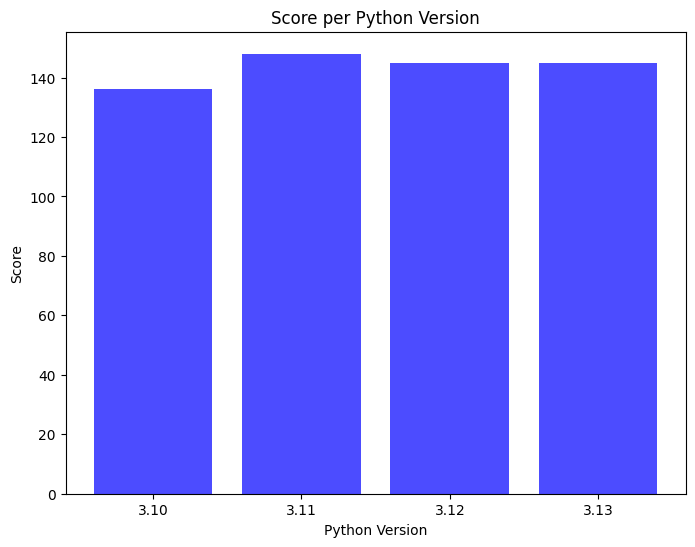

In [123]:
per_version = data_matrix.sum(axis=1)
plt.figure(figsize=(8, 6))
plt.bar(versions, per_version, color='blue', alpha=0.7)
plt.title("Score per Python Version")
plt.xlabel("Python Version")
plt.ylabel("Score")
plt.show()


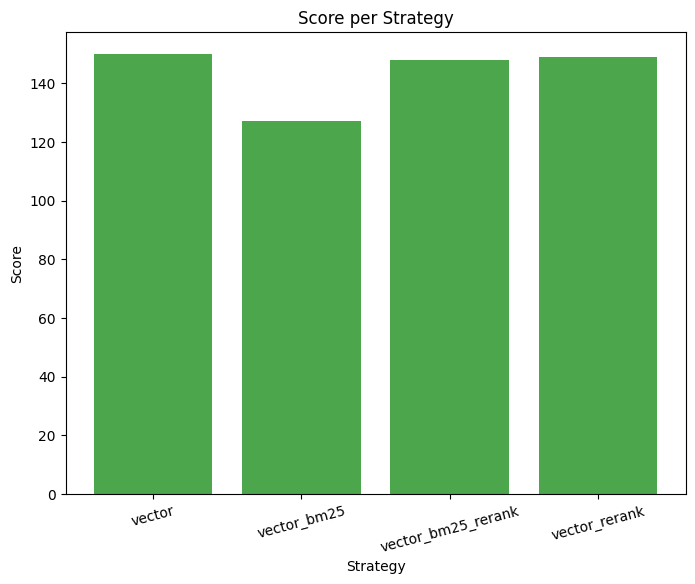

In [126]:
per_strategy = data_matrix.sum(axis=0)
plt.figure(figsize=(8, 6))
plt.bar([s.value for s in strategies], per_strategy, color='green', alpha=0.7)
plt.title("Score per Strategy")
plt.xlabel("Strategy")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.show()

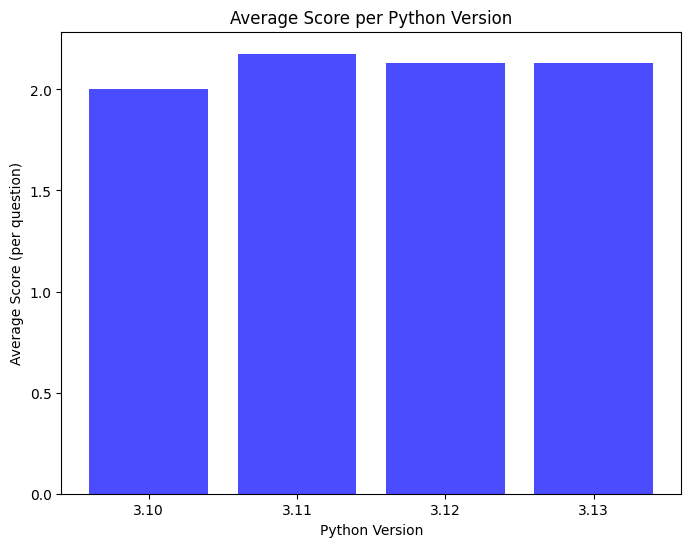

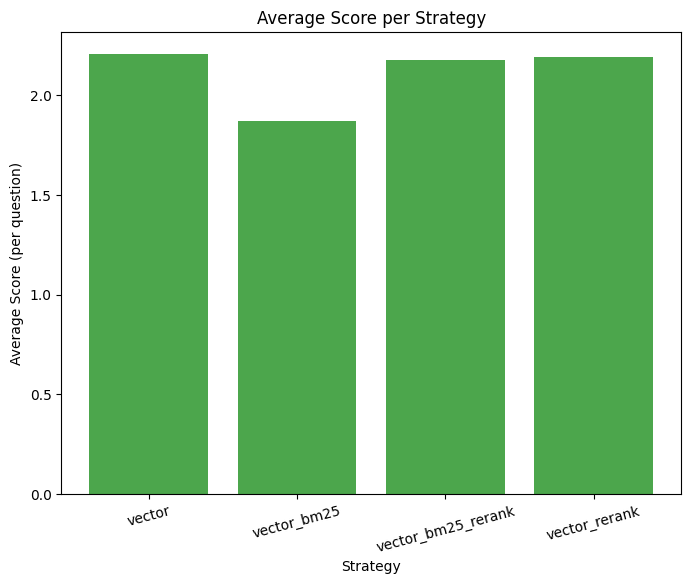

In [129]:
num_questions = 17

avg_per_version = data_matrix.sum(axis=1) / (num_questions * 4)
plt.figure(figsize=(8, 6))
plt.bar(versions, avg_per_version, color='blue', alpha=0.7)
plt.title("Average Score per Python Version")
plt.xlabel("Python Version")
plt.ylabel("Average Score (per question)")
plt.show()


avg_per_strategy = data_matrix.sum(axis=0) / (num_questions * 4)
plt.figure(figsize=(8, 6))
plt.bar([s.value for s in strategies], avg_per_strategy, color='green', alpha=0.7)
plt.title("Average Score per Strategy")
plt.xlabel("Strategy")
plt.ylabel("Average Score (per question)")
plt.xticks(rotation=15)
plt.show()

In [94]:
strategy_scores = {}
num_docs_scores = {}
num_questions = 17

In [95]:
for (num_docs, strategy), total_score in score_best_answers.items():
    avg_score = total_score / num_questions 

    if strategy not in strategy_scores:
        strategy_scores[strategy] = []
    strategy_scores[strategy].append(avg_score)

    if num_docs not in num_docs_scores:
        num_docs_scores[num_docs] = []
    num_docs_scores[num_docs].append(avg_score)



In [98]:
print(strategy_scores)

{<ChatModelStrategyEnum.VECTOR: 'vector'>: [3.823529411764706, 4.117647058823529, 4.294117647058823], <ChatModelStrategyEnum.VECTOR_BM25: 'vector_bm25'>: [3.9411764705882355, 4.117647058823529, 4.176470588235294], <ChatModelStrategyEnum.VECTOR_RERANK: 'vector_rerank'>: [4.235294117647059, 3.9411764705882355, 4.235294117647059], <ChatModelStrategyEnum.VECTOR_BM25_RERANK: 'vector_bm25_rerank'>: [4.176470588235294, 4.0, 4.176470588235294]}


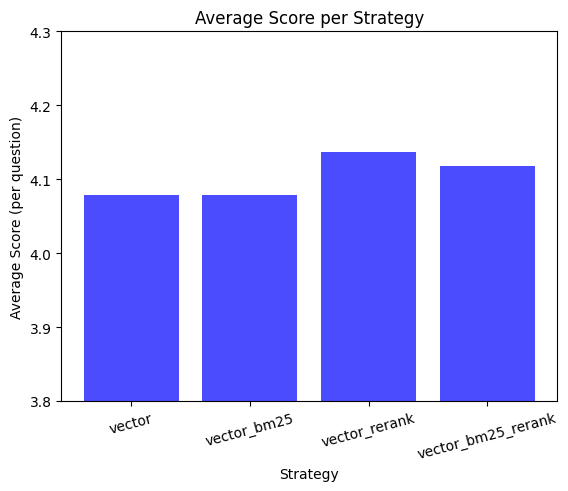

In [110]:
strategies = list(strategy_scores.keys())
strategy_labels = [s.value for s in strategies]
avg_per_strategy = [np.mean(strategy_scores[s]) for s in strategies]
plt.bar(strategy_labels, avg_per_strategy, color='blue', alpha=0.7)
plt.title("Average Score per Strategy")
plt.xlabel("Strategy")
plt.ylabel("Average Score (per question)")
plt.ylim(3.8, 4.3)
plt.xticks(rotation=15)
plt.show()


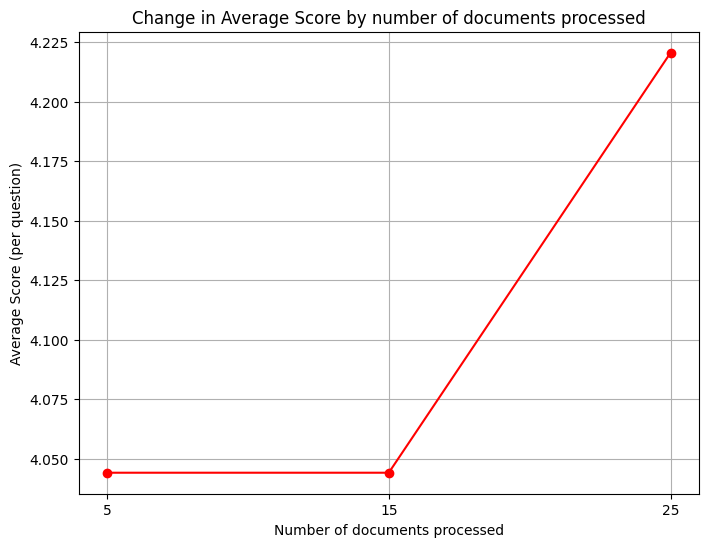

In [112]:
plt.figure(figsize=(8, 6))
num_docs_values = num_docs_scores.keys()
avg_per_num_docs = [np.mean(num_docs_scores[n]) for n in num_docs_values]
plt.plot(num_docs_values, avg_per_num_docs, marker="o", linestyle="-", color="red")
plt.title("Change in Average Score by number of documents processed")
plt.xlabel("Number of documents processed")
plt.ylabel("Average Score (per question)")
selected_ticks = [n for n in num_docs_values if n in [5, 15, 25]]
plt.xticks(selected_ticks)
plt.grid(True)
plt.show()

In [124]:
strategy_scores = defaultdict(list)
num_docs_scores = defaultdict(list)

for (num_docs, question_index, strategy), score in score_best_answers.items():
    if score != -1: 
        strategy_scores[strategy].append(score)
        num_docs_scores[num_docs].append(score)

avg_per_strategy = {strategy: np.mean(scores) for strategy, scores in strategy_scores.items()}

avg_per_num_docs = {num_docs: np.mean(scores) for num_docs, scores in num_docs_scores.items()}


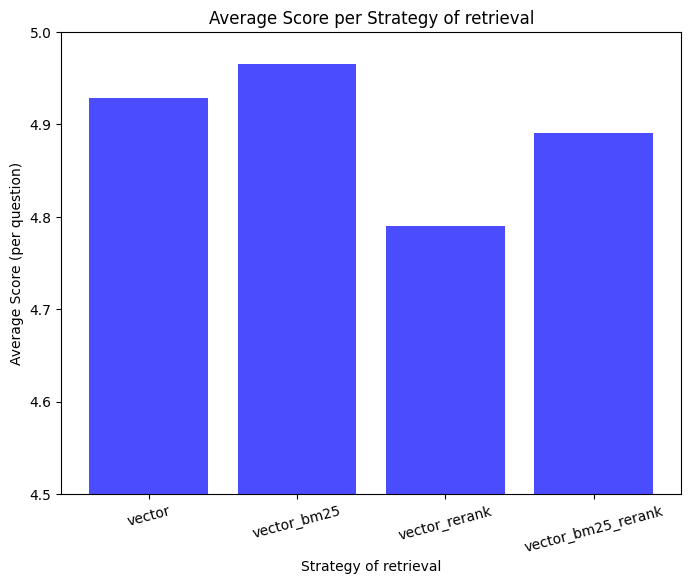

In [127]:
plt.figure(figsize=(8, 6))
plt.bar([s.value for s in avg_per_strategy.keys()], avg_per_strategy.values(), color='blue', alpha=0.7)
plt.title("Average Score per Strategy of retrieval")
plt.xlabel("Strategy of retrieval")
plt.ylabel("Average Score (per question)")
plt.xticks(rotation=15)
plt.ylim(4.5, 5)
plt.show()

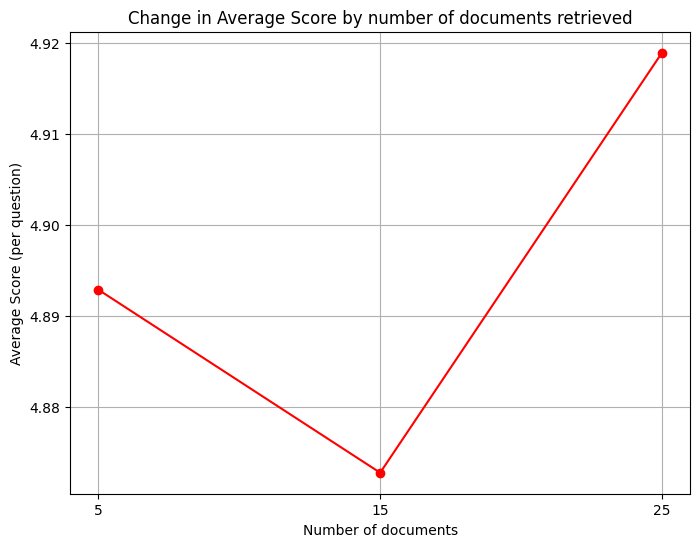

In [128]:
plt.figure(figsize=(8, 6))
num_docs_values = sorted(avg_per_num_docs.keys())
plt.plot(num_docs_values, [avg_per_num_docs[n] for n in num_docs_values], marker="o", linestyle="-", color="red")
plt.title("Change in Average Score by number of documents retrieved")
plt.xlabel("Number of documents")
plt.ylabel("Average Score (per question)")
plt.grid(True)
plt.xticks([5, 15, 25])
plt.show()

In [129]:
strategy_times = defaultdict(list)
num_docs_times = defaultdict(list)

In [135]:

for (num_docs, question_index, strategy), (response, total_time) in test_responses.items():
    strategy_times[strategy].append(total_time)
    num_docs_times[num_docs].append(total_time)

avg_time_per_strategy = {strategy: np.mean(times) for strategy, times in strategy_times.items()}

avg_time_per_num_docs = {num_docs: np.mean(times) for num_docs, times in num_docs_times.items()}


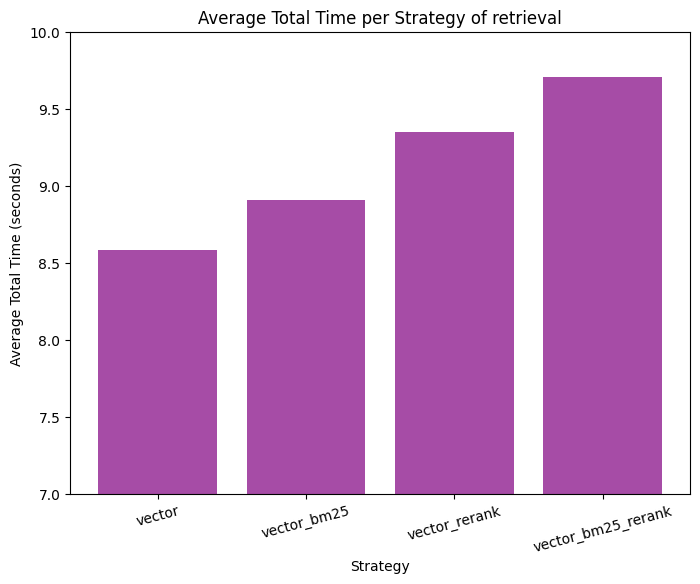

In [136]:
plt.figure(figsize=(8, 6))
plt.bar([s.value for s in avg_time_per_strategy.keys()], avg_time_per_strategy.values(), color='purple', alpha=0.7)
plt.title("Average Total Time per Strategy of retrieval")
plt.xlabel("Strategy")
plt.ylabel("Average Total Time (seconds)")
plt.xticks(rotation=15)
plt.ylim(7,10)
plt.show()

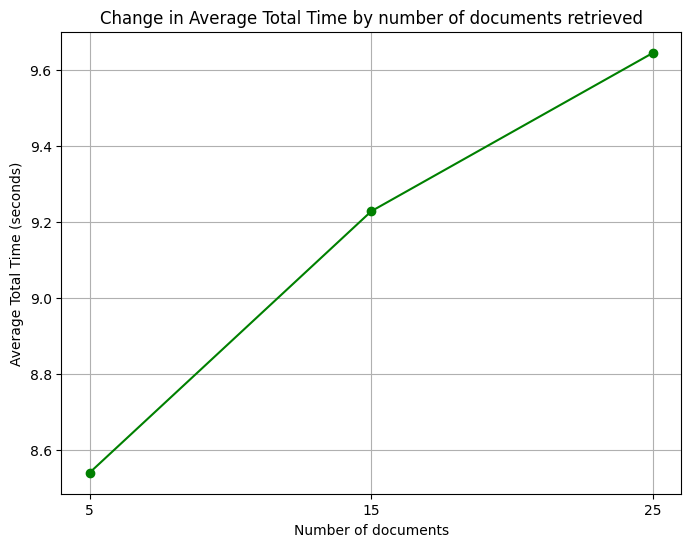

In [137]:
plt.figure(figsize=(8, 6))
num_docs_values = sorted(avg_time_per_num_docs.keys())
plt.plot(num_docs_values, [avg_time_per_num_docs[n] for n in num_docs_values], marker="o", linestyle="-", color="green")
plt.title("Change in Average Total Time by number of documents retrieved")
plt.xlabel("Number of documents")
plt.ylabel("Average Total Time (seconds)")
plt.grid(True)
plt.xticks([5, 15, 25])
plt.show()